# Instruções

1. Resolva todos os exercícios abaixo.
2. Salve uma cópia desse notebook em um repositório no GitHub.
3. Envie o link do repositório criado para o professor.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1. Restauração de imagens usando a Transformada Rápida de Fourier

 A Transformada Rápida de Fourier converte uma image do domínio do espaço para uma representação no domínio da frequência. 
 
 Faça uma análise das frequências obtidas para a [imagem](https://drive.google.com/file/d/1Udgllcno-XQOfE1RrIXGuiCopFYhn0pR/view?usp=sharing) abaixo e, utilizando uma máscara apropriada, remova as frequências indesejadas para remover o ruído.

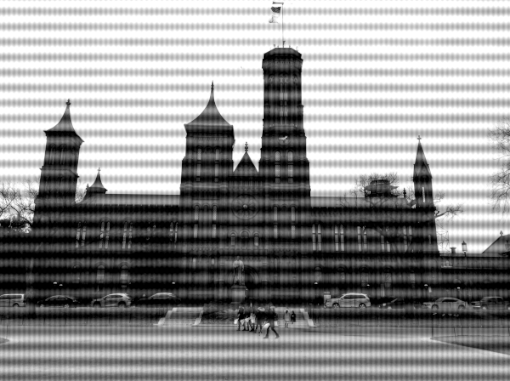

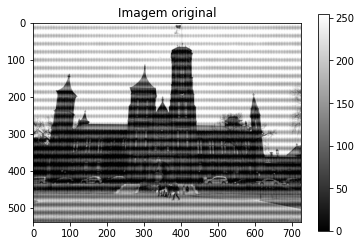

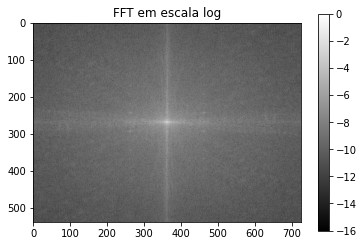

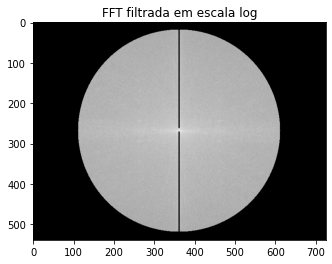

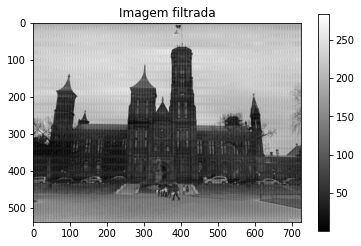

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack as fp

img = cv2.imread('/content/drive/MyDrive/ProcessamentoDigitaldeImagens/castelo.jpg', 0) # imagem de entrada

w, h = img.shape # w = h = 500
H = np.zeros((w, h)) # filtro

mid = h//2

R = 250 #raio do circulo maior
r = 100 # distancia do centro

cv2.circle(H,(h//2,w//2), R, 1, -1) # circulo mais externo (valores dentro do circulo sao iguais a 1)

# remove frequencias dentro do circulo
# as linhas desenhadas possuem dois pixels de largura
cv2.line(H,(mid,mid-90),(mid,mid+R), 0, 2)
cv2.line(H,(mid,mid-100),(mid,mid-R-100), 0, 2)

# colormap (escala de cinza)
cmap='gray'

plt.figure()
plt.title('Imagem original')
plt.imshow(img, cmap=cmap)
plt.colorbar()

H = fp.fftshift(H) #filtro passa-baixa
F = fp.fft2(img)

#tratando a FFT para os gráficos
Fm = np.absolute(F)
Fm /= Fm.max()
Fm = fp.fftshift(Fm)
Fm = np.log(Fm)

#mostrando a FFT em escala logaritmica
plt.figure()
plt.title('FFT em escala log')
plt.imshow(Fm, cmap=cmap)
plt.colorbar()

# aplicando o filtro
Fg = F*H
plt.figure()
plt.title('FFT filtrada em escala log')
Fga = np.absolute(Fg)
Fga = fp.fftshift(Fga)
Fga = np.log(Fga+1e-6)
plt.imshow(Fga, cmap=cmap)

# obtendo a transformada inversa, que é o sinal original (a imagem) filtrado
f_blurred = fp.ifft2(Fg)
f_blurred = np.absolute(f_blurred)

plt.figure()
plt.title('Imagem filtrada')
plt.imshow(f_blurred, cmap=cmap)
plt.colorbar()

plt.show()

#plt.imshow(circle)
plt.show()


#2. Erosão e Dilatação

Crie duas funções chamadas videoErosao e videoDilatacao.

A função videoErosao() receberá uma imagem em preto e branco como a apresentada abaixo e deverá aplicar a operação de erosão sucessivamente, até ela desaparecer. Faça um vídeo que aplique essa operação aos poucos, em formato de animação.

Realize procedimento semelhante para videoDilatacao(), porém fazendo o oposto da operação de dilatação.

OBS: <a href="https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html">Esse texto deverá ajudar</a>.

E para gerar o vídeo, <a href="https://colab.research.google.com/drive/1sQAxhv5nIWDvwt82osa2x41zVtUFyx1O?usp=sharing">clique aqui</a>.

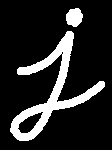

In [ ]:
import numpy as np
import cv2

#Função que realiza a erosão da imagem
def erosao(image,i):
	kernel = np.ones((i,i),np.uint8)
	erosao = cv2.erode(image,kernel,iterations=1)
	return erosao

#Função que realiza dilatação da imagem
def dilatacao(image, i):
	kernel = np.ones((i,i),np.uint8)
	dilatacao =cv2.dilate(image, kernel, iterations = 1)
	return dilatacao

#Gerar os vídeos de saída
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
videoDilatacao = cv2.VideoWriter("Dilatacao.avi", fourcc, 20.0, (640, 480))
videoErosao = cv2.VideoWriter("Erosao.avi", fourcc, 20.0, (640, 480))
image = cv2.imread('2.png')
for i in range (1,150):
	#Aplicando a função erosao na imagem.
	fErosao=erosao(image, i)
	#Alterando o tamanho da imagem
	fErosao2 = cv2.resize(fErosao, (640, 480), interpolation = cv2.INTER_AREA)
	videoErosao.write(fErosao2)
	#Aplicando a funcao dilatacao na imagem.
	fDilatacao=dilatacao(image, i)
	#Alterando o tamanho da imagem
	fDilatacao2 = cv2.resize(fDilatacao, (640, 480), interpolation = cv2.INTER_AREA)
	videoDilatacao.write(fDilatacao2)
videoErosao.release()
videoDilatacao.release()

Links para os vídeos:
Erosao:
https://drive.google.com/file/d/1SSAB2PkEz1eTLMuY131rrIiv8YYOpebz/view?usp=sharing
Dilatação:
https://drive.google.com/file/d/1h8_1GkGEaabEsKlK55pWxfBlQthWxvTQ/view?usp=sharing


#3. Detecção de linhas usando a Transformada de Hough

A Transformada de Hough é uma técnica que auxilia na detecção de formas geométricas em imagens digitais. 

Nesta aplicação, você deverá identificar as linhas que limitam uma via para que um carro autônomo possa seguir em tempo real. Devido a mudanças de iluminação, será necessário utilizar a transformada de Hough para conectar retas desconectadas. Utilize o seguinte [vídeo](https://drive.google.com/file/d/1G33NiG3rQuec-1hC-FshmjhLWiU1bGtO/view?usp=sharing) como entrada do algoritmo. O resultado de um frame deve ser como a imagem abaixo.

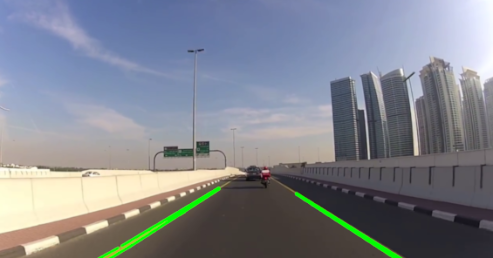

In [ ]:
import cv2
import numpy as np
import sys
from matplotlib import pyplot as plt
#Importa o vídeo
captura = cv2.VideoCapture("road_car_view.mp4")
#Enquanto o não fecha 
while (True):
    #Le o cada frame do video
    _,framesVideo = captura.read()
    #Cópia das frames
    dst = np.copy(framesVideo)
    th1 = 650
    th2 = th1*0.4
    #Máscara para seguir o amarelo
    minimum= np.array([20, 55, 119])
    maximum = np.array([24, 255, 255])
    framesVideoHSV = cv2.cvtColor(framesVideo, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(framesVideoHSV, minimum, maximum)
    #Obtendo as arestas
    edges = cv2.Canny(mask, th1, th2)
    # Aplicando a transformação de linha de hough probabilística
    lines = cv2.HoughLinesP(edges, 2, np.pi/180.0, 50, minLineLength=50, maxLineGap=10)
    #Desenhando linhas ao encontrar os pontos
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(dst, (x1,y1), (x2,y2), (0,255,0), 3)
        
    #Resultado
    cv2.imshow("Resultado", dst)
    cv2.imshow("lines", edges)
   
    if cv2.waitKey(25) & 0xFF == ord('q'):
       break

cv2.destroyAllWindows()

#4. Segmentação de Imagens com K-Means

Quando falamos de segmentação de imagens, dizemos que vamos localizar segmentos das imagens. Um algoritmo que realiza essa tarefa é o K-Means.

No vídeo abaixo é apresentado como usar esse algoritmo para fazer quantização de imagens, ou seja, representar as cores originais em menos quantidades.

Dito isso, assista o vídeo abaixo e implemente um algoritmo que transforma qualquer imagem em um gráfico para jogo 8 bits. Assim, pegue uma imagem e gere ela novamente com apenas 256 cores usando o K-means.

<a href="https://www.youtube.com/watch?v=iHlve4t5z-0"><img src="https://img.youtube.com/vi/iHlve4t5z-0/mqdefault.jpg"/></a>

OBS: O algoritmo K-means é discutido em mais detalhes nos vídeos abaixo.

<a href="https://www.youtube.com/watch?v=2hsMErlQtcI"><img src="https://img.youtube.com/vi/2hsMErlQtcI/mqdefault.jpg"/></a>
<a href="https://www.youtube.com/watch?v=p2twwtegYkU"><img src="https://img.youtube.com/vi/p2twwtegYkU/mqdefault.jpg"/></a>

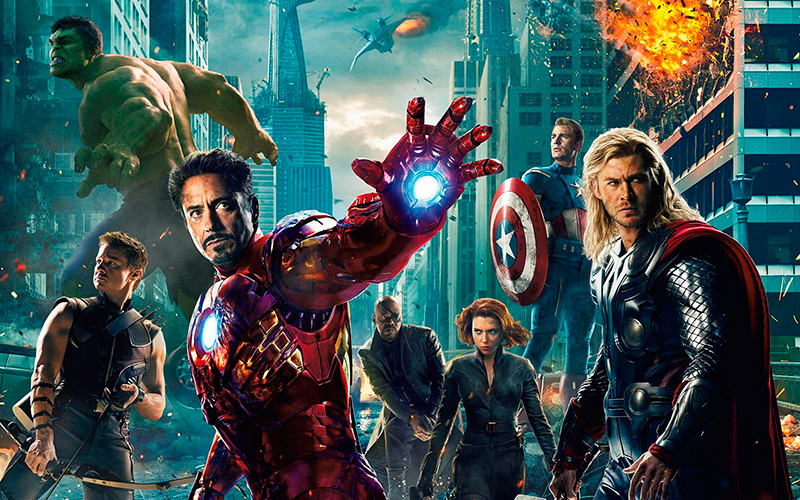

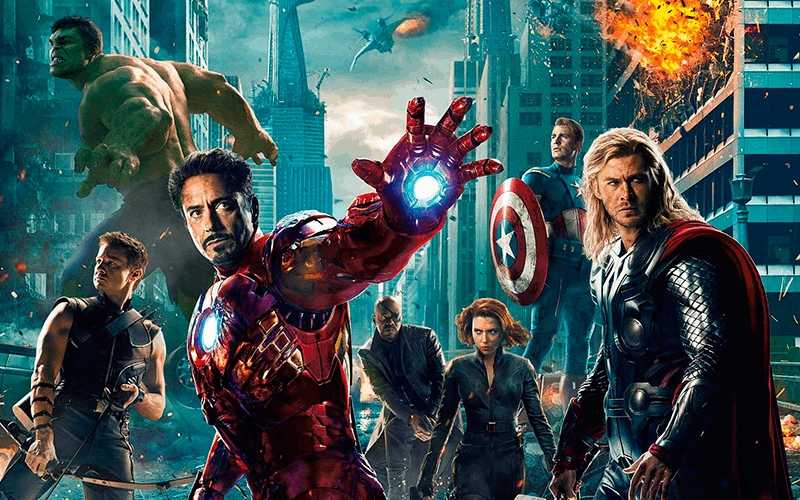

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#Função K-means
def computeKmeans(imagem):
  #Numero de cores
	K = 256
	#Alterando a largura e a altura
	matriz = imagem.reshape((-1,3))
	matriz = np.float32(matriz)
	#Interrompendo o Kmeans
	criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1) 
	#Aplicando K-Means
	_, labels, centroides = cv2.kmeans(matriz, K, None, criteria, 30, cv2.KMEANS_RANDOM_CENTERS)
	#Cores que estão no centroide
	centroides = np.uint8(centroides)
	imagemComCentroides = centroides[labels.flatten()]
	imagemKmeans = imagemComCentroides.reshape((imagem.shape))
	cv2_imshow(imagem)
	cv2_imshow(imagemKmeans)
#função main
if __name__ == "__main__":
	
	img = cv2.imread('/content/drive/MyDrive/ProcessamentoDigitaldeImagens/vingadores.jpg')
	computeKmeans(img)

#5. Segmentação usando o algoritmo GrabCut

Quando o assunto é obter o segmento exato que contém um objeto, o algoritmo GrabCut é excelente.

Nos vídeos abaixos há exemplos de sua implementação. 

<a href="https://www.youtube.com/watch?v=HBp6vQXFQgc"><img src="https://img.youtube.com/vi/HBp6vQXFQgc/mqdefault.jpg"/></a>
<a href="https://www.youtube.com/watch?v=DyRfAIQfVug"><img src="https://img.youtube.com/vi/DyRfAIQfVug/mqdefault.jpg"/></a>

Baseado nisso e nos conhecimentos anteriores, crie um algoritmo que segmente sua imagem e adicione por cima do fundo o efeito de borramento, usando um dos filtros explicados em lições passadas.

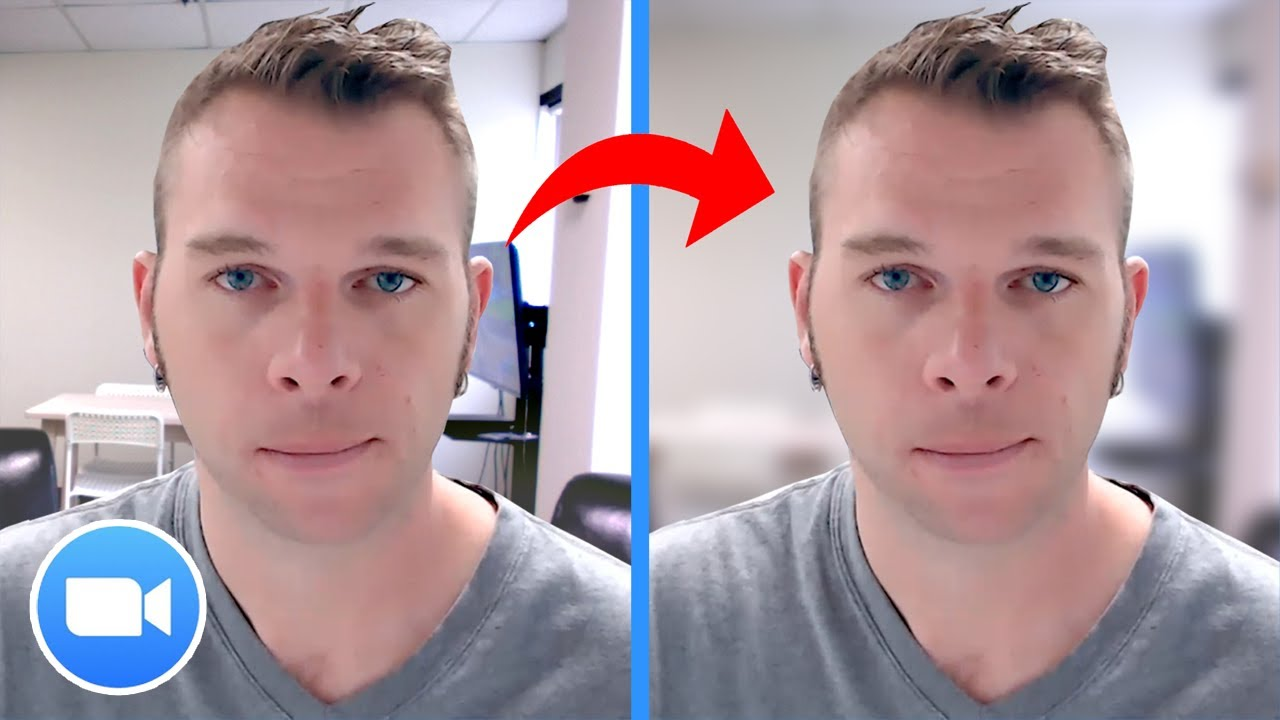

In [ ]:
# -*- coding: cp1252 -*-
from tkinter import *
from PIL import Image
from PIL import ImageTk
#import tkinter.tkFileDialog
from tkinter import filedialog
#import tkFileDialog
import cv2
import numpy as np

class GrabCutGUI(Frame):
    def __init__(self, master = None):
        #invoca o construtor da classe pai Frame
        Frame.__init__(self, master)

        #inicializar a interface gráfica
        self.iniciaUI()

    def iniciaUI(self):
        #preparando a janela
        self.master.title("Janela da Imagem Segmentada")
        self.pack()

        #computa ações de mouse
        self.computaAcoesDoMouse()

        #carregando a imagem do disco
        self.imagem, self.imagemBlur = self.carregaImagemASerExibida()
        #cv2.imshow("", self.imagem)
        #criar um canvas que receberá a imagem
        self.canvas = Canvas(self.master, width = self.imagem.width(), height = self.imagem.height(), cursor = "cross")

        #desenhar a imagem que carreguei no canvas
        self.canvas.create_image(0, 0, anchor = NW, image = self.imagem)
        self.canvas.image = self.imagem #pra imagem não ser removida pelo garbage collector

        #posiciona todos os elementos no canvas
        self.canvas.pack()

    def computaAcoesDoMouse(self):
        self.startX = None
        self.startY = None
        self.rect   = None
        self.rectangleReady = None
        
        self.master.bind("<ButtonPress-1>", self.callbackBotaoPressionado)
        self.master.bind("<B1-Motion>", self.callbackBotaoPressionadoEmMovimento)
        self.master.bind("<ButtonRelease-1>", self.callbackBotaoSolto)

    def callbackBotaoSolto(self, event):
        if self.rectangleReady:
            #criar uma nova janela
            windowGrabcut = Toplevel(self.master)
            windowGrabcut.wm_title("Segmentation")
            windowGrabcut.minsize(width = self.imagem.width(), height = self.imagem.height())
            
            #criar canvas pra essa nova janela
            canvasGrabcut = Canvas(windowGrabcut, width = self.imagem.width(), height = self.imagem.height())
            canvasGrabcut.pack()

            #aplicar grabcut na imagem
            mask = np.zeros(self.imagemOpenCV.shape[:2], np.uint8)
            #print(mask.shape)
            rectGcut = (int(self.startX), int(self.startY), int(event.x - self.startX), int(event.y - self.startY))
            fundoModel = np.zeros((1, 65), np.float64)
            objModel = np.zeros((1, 65), np.float64)

            #invocar grabcut
            cv2.grabCut(self.imagemOpenCV, mask, rectGcut, fundoModel, objModel, 5, cv2.GC_INIT_WITH_RECT)

            #preparando imagem final
            maskFinal = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
            imgFinal = self.imagemOpenCV * maskFinal[:,:,np.newaxis]
            #Convertendo o formato PhotoImage para PIL
            imgBlur = ImageTk.getimage(self.imagemBlur)
            #Convertendo do formato PIL para OPENCV
            self.opencvImageBlur = cv2.cvtColor(np.array(imgBlur), cv2.COLOR_RGB2BGR)
            for x in range(0, self.imagemOpenCV.shape[1]):
                for y in range(0, self.imagemOpenCV.shape[0]):
                    if(maskFinal[y][x] == 0):
                        imgFinal [y][x][0] = self.opencvImageBlur[y][x][0]
                        imgFinal [y][x][1] =  self.opencvImageBlur[y][x][1] 
                        imgFinal[y][x][2] =  self.opencvImageBlur[y][x][2]
            #converter de volta do opencv pra Tkinter
            imgFinal = cv2.cvtColor(imgFinal, cv2.COLOR_BGR2RGB)
            imgFinal = Image.fromarray(imgFinal)
            imgFinal = ImageTk.PhotoImage(imgFinal)

            #inserir a imagem segmentada no canvas
            canvasGrabcut.create_image(0, 0, anchor = NW, image = imgFinal)
            canvasGrabcut.image = imgFinal          

    def callbackBotaoPressionadoEmMovimento(self, event):
        #novas posicoes de x e y
        currentX = self.canvas.canvasx(event.x)
        currentY = self.canvas.canvasy(event.y)

        #atualiza o retângulo a ser desenhado
        self.canvas.coords(self.rect, self.startX, self.startY, currentX, currentY)

        #verifica se existe retângulo desenhado
        self.rectangleReady = True

    def callbackBotaoPressionado(self, event):
        #convertendo o x do frame, pro x do canvas e copiando isso em startX
        self.startX = self.canvas.canvasx(event.x)
        self.startY = self.canvas.canvasy(event.y)

        if not self.rect:
            self.rect = self.canvas.create_rectangle(0, 0, 0, 0, outline="blue")


    def carregaImagemASerExibida(self):
        caminhoDaImagem = filedialog.askopenfilename()

        #se a imagem existir, entra no if
        if(caminhoDaImagem != None):
            self.imagemOpenCV = cv2.imread(caminhoDaImagem)

            #converte de opencv para o formato PhotoImage
            image = cv2.cvtColor(self.imagemOpenCV, cv2.COLOR_BGR2RGB)
            imagemBlur = cv2.blur(image,(10,10))
            #converte de OpenCV pra PIL
            image = Image.fromarray(image)
            imagemBlur = Image.fromarray(imagemBlur)
            #converte de PIL pra PhotoImage
            image = ImageTk.PhotoImage(image)
            imagemBlur = ImageTk.PhotoImage(imagemBlur)
            return [image, imagemBlur]
            

def main():
    #inicializa a Tkinter
    root = Tk()

    #cria a aplicação
    appcut = GrabCutGUI(master = root)

    #cria o loop do programa
    appcut.mainloop()
    

if __name__ == "__main__":
    main()


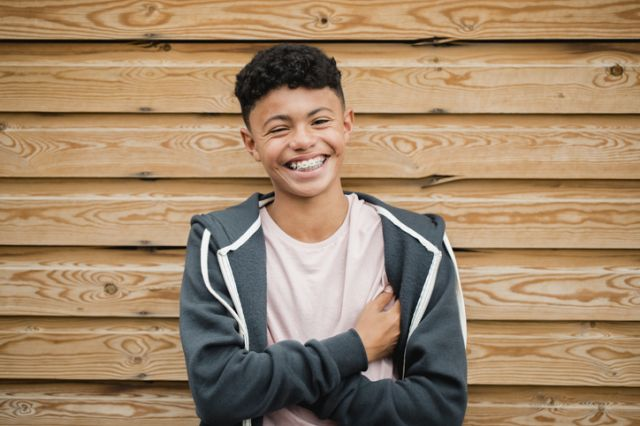

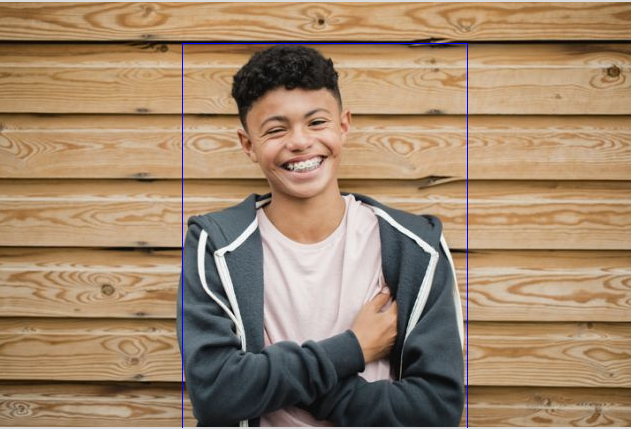

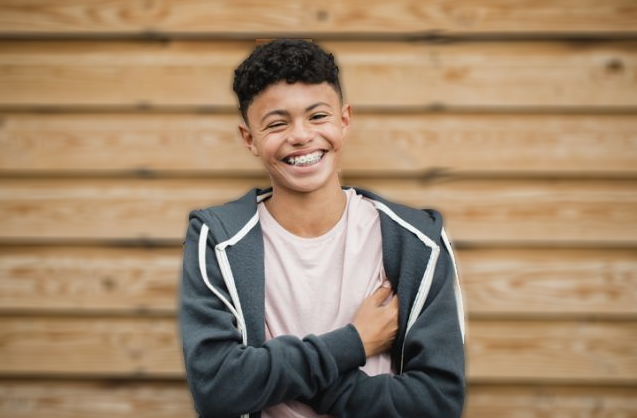

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

#RESULTADOS OBTIDOS
img = cv2.imread('/content/drive/MyDrive/ProcessamentoDigitaldeImagens/image.jpg')
img1 = cv2.imread('/content/drive/MyDrive/ProcessamentoDigitaldeImagens/riscando.png')
img2 = cv2.imread('/content/drive/MyDrive/ProcessamentoDigitaldeImagens/embacada.png')
cv2_imshow(img)
cv2_imshow(img1)
cv2_imshow(img2)